In [38]:
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [39]:
def process_file_and_update_value(file_path, target, new_value, is_mult = False, inflows=False):
        """
        Process the specified file, search for the target string, and update its value.

        Args:
            file_path (str): The path of the file to process.
            target (str): The string to search for in the file.
            new_value (str): The new value to replace the found target string.
            is_mult (bool): new_value has multiple values corresponding to multiple lines in setup/driver file
        """
        with open(file_path, 'r') as file:
            lines = file.readlines()

        with open(file_path, 'w') as file:
            target_section = False
            value_updated = False

            for line in lines:
                line = line.strip()

                if line.startswith("#"):
                    # Skip lines starting with #
                    continue

                elif line.startswith("end"):
                    # Stop processing further lines after encountering "end"
                    if value_updated==False:
                        file.write(f'{target} {new_value}\n{line}\n')
                    else:
                        file.write(line + "\n")
                    break

                elif (line.split()[0] == "fileinflow" or line.split()[0] == "fileoutflow") and new_value is None:
                    file.write(f"#{line}\n")
                    value_updated = True
                    continue
                elif target in line and not is_mult:
                    file.write(f"{target} {new_value}\n")
                    value_updated = True
                elif target in line and is_mult:
                    if isinstance(new_value, list):

                        file.write(f"{target} {len(new_value)} \n")
                        file.write("\n".join(map(str, new_value)) + "\n")
                    else:

                        file.write(f"{target} {len(new_value)} \n")
                        file.write(new_value.to_string(index=False, header=False) + "\n")
                    target_section = True
                elif re.match(r'^\d', line) and target_section:
                    continue
                elif not re.match(r'^\d', line) and target_section:
                    target_section = False
                    file.write(line + "\n")
                    value_updated = True
                else:
                    # Copy the line as is
                    file.write(line + "\n")

def mod_inflows_outflows_steady_state(path_to_meteo_file, setup_file, inflow_keys, inflow_values, 
                                          years_to_apply=None, months_to_apply=None):
        
        #values are going to be a dictionary where each key will be about
        inflows_path = path_to_meteo_file.split('.dat')[0]+'_inflows.dat'
        outflows_path = path_to_meteo_file.split('.dat')[0]+'_outflows.dat'
        meteo_df = pd.read_csv(path_to_meteo_file)
        num_lines = len(meteo_df)
        inflows_df = pd.DataFrame(columns=['Date', 'width', 'U', 'temp', 'sal', 'Ux', 'Uy', 'DOC', 'POC', 'DIC', 'CH4', 'O2'])
        inflows_df['Date'] = pd.to_datetime(meteo_df[['Year', 'Month', 'Day']]).dt.strftime('%Y%m%d')
        inflows_df = inflows_df.fillna(-999)
        
        if years_to_apply is None:
            years_to_apply = meteo_df['Year'].unique()
        
        if months_to_apply is None:
            months_to_apply = meteo_df['Month'].unique()
        #populate inflow columns based on supplied dictionary
        for key, value in zip(inflow_keys, inflow_values): 
            inflows_df.loc[(pd.to_datetime(inflows_df['Date']).dt.year.isin(years_to_apply)) & 
                           (pd.to_datetime(inflows_df['Date']).dt.month.isin(months_to_apply)), key] = value
            
            inflows_df.loc[~(pd.to_datetime(inflows_df['Date']).dt.year.isin(years_to_apply)) | 
                           ~(pd.to_datetime(inflows_df['Date']).dt.month.isin(months_to_apply)), key] = 0

        inflows_df.to_csv(inflows_path, index=False, sep=' ', header=False)
        outflows_df = pd.DataFrame(columns=['Date', 'width', 'U'])
        outflows_df['Date'] = inflows_df['Date']
        outflows_df['width'] = inflows_df['width']
        outflows_df['U'] = inflows_df['U']
        outflows_df.to_csv(outflows_path, index=False, sep=' ', header=False)

        process_file_and_update_value(setup_file, target='tribheat', new_value=2)
        #self.process_file_and_update_value(setup_file, target='tribheat', new_value=0)
        #self.find_target(["N_tribin"],1,1)
        process_file_and_update_value(setup_file, target='N_triblev', new_value=1)
        process_file_and_update_value(setup_file, target='iefflloc', new_value=1)
        process_file_and_update_value(setup_file, target='fileinflow', new_value=inflows_path.split('/')[-1])
        process_file_and_update_value(setup_file, target='fileoutflow', new_value=outflows_path.split('/')[-1])

In [40]:
columns=['Date', 'width', 'U', 'temp', 'sal', 'Ux', 'Uy', 'DOC', 'POC', 'DIC', 'CH4', 'O2']

In [41]:
'''
path_to_meteo_file = '../multi_processing/results/YKD-burned-dynamic-ch4/meteo/YKD-burned-sa-0.dat'
inflows_path = path_to_meteo_file.split('.dat')[0]+'_inflows.dat'
setup_file = '../multi_processing/results/YKD-burned-dynamic-ch4/setup/YKD-burned-sa-0_setup.dat'
path_to_auto_ch4_fluxes = '../data/YKD/in_situ/auto_fluxes/auto_fluxes_all.csv'
'''

path_to_meteo_file = '/home/amullen/LAKE_FCS/meteo/YKD-unburned-2024.dat'
inflows_path = '/home/amullen/LAKE_FCS/meteo/YKD-unburned-2024_inflows.dat'
setup_file = '/home/amullen/LAKE_FCS/setup/YKD-unburned-2024_setup.dat'
path_to_auto_ch4_fluxes = '/home/amullen/Lake-Model-Data/data/YKD/in_situ/auto_fluxes/auto_fluxes_all.csv'

#path_to_meteo_file = '/home/amullen/LAKE/meteo/Darro.dat'
#inflows_path = '/home/amullen/LAKE/meteo/Darro_inflows.dat'
#setup_file = '/home/amullen/LAKE/setup/Darro.dat'
#path_to_auto_ch4_fluxes = '/home/amullen/Lake-Model-Data/data/Brazil/in_situ/auto_fluxes_all.csv'

#path_to_meteo_file = '/home/amullen/LAKE/meteo/Cascavel.dat'
#inflows_path = '/home/amullen/LAKE/meteo/Cascavel_inflows.dat'
#setup_file = '/home/amullen/LAKE/setup/Cascavel.dat'
#path_to_auto_ch4_fluxes = '/home/amullen/Lake-Model-Data/data/Brazil/in_situ/auto_fluxes_all.csv'



In [42]:
#open auto flux data
auto_fluxes = pd.read_csv(path_to_auto_ch4_fluxes)

auto_fluxes = auto_fluxes.rename(columns={'Date': 'date'})
auto_fluxes['date'] = pd.to_datetime(auto_fluxes['date'])

#auto_fluxes=auto_fluxes.loc[auto_fluxes['date']>pd.to_datetime('2024-03-01')]

auto_fluxes['doy'] = auto_fluxes['date'].dt.day_of_year
auto_fluxes['ddmm'] = pd.to_datetime('2023-01-01') + pd.to_timedelta(auto_fluxes['doy'] - 1, unit='D')
auto_fluxes['Year'] = auto_fluxes['date'].dt.year
max_date = auto_fluxes['date'].max()
min_date = auto_fluxes['date'].min()

#average chambers together
auto_fluxes = auto_fluxes[['pond', 'chamber', 'date', 'mg_m2_d_diff_ch4']].groupby(by=['pond','date']).mean().reset_index().drop(columns=['chamber'])

#create date range from minimum to maximum observation dates at one day interval to ensure seamless timeseries
date_range = pd.DataFrame({'date':pd.date_range(min_date, max_date, freq='1D')})

#extract burned data
auto_fluxes_burned = auto_fluxes.loc[auto_fluxes['pond']=='burned']
auto_fluxes_unburned = auto_fluxes.loc[auto_fluxes['pond']=='unburned']
#auto_fluxes_burned = auto_fluxes.loc[auto_fluxes['pond']=='D']
#auto_fluxes_burned = auto_fluxes.loc[auto_fluxes['pond']=='C']

#merge with date range
auto_fluxes_burned = pd.merge(auto_fluxes_burned, date_range, on='date', how='right')
auto_fluxes_burned = auto_fluxes_burned.drop(columns=['pond'])

#fill missing data
auto_fluxes_burned['mg_m2_d_diff_ch4'] = auto_fluxes_burned['mg_m2_d_diff_ch4'].interpolate(method='linear')
auto_fluxes_burned['mg_m2_d_diff_ch4'] = auto_fluxes_burned['mg_m2_d_diff_ch4'].ffill()
auto_fluxes_burned['mg_m2_d_diff_ch4'] = auto_fluxes_burned['mg_m2_d_diff_ch4'].bfill()

#extract unburned data
#auto_fluxes_unburned = auto_fluxes.loc[auto_fluxes['pond']=='unburned']
#auto_fluxes_unburned = auto_fluxes.loc[auto_fluxes['pond']=='C']

#merge with date range
auto_fluxes_unburned = pd.merge(auto_fluxes_unburned, date_range, on='date', how='right')
auto_fluxes_unburned = auto_fluxes_unburned.drop(columns=['pond'])

#fill missing data
auto_fluxes_unburned['mg_m2_d_diff_ch4'] = auto_fluxes_unburned['mg_m2_d_diff_ch4'].interpolate(method='linear')
auto_fluxes_unburned['mg_m2_d_diff_ch4'] = auto_fluxes_unburned['mg_m2_d_diff_ch4'].ffill()
auto_fluxes_unburned['mg_m2_d_diff_ch4'] = auto_fluxes_unburned['mg_m2_d_diff_ch4'].bfill()

<Axes: xlabel='date', ylabel='mg_m2_d_diff_ch4'>

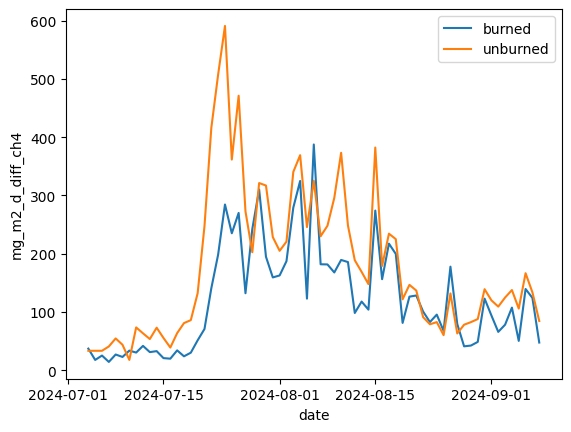

In [43]:
sns.lineplot(data=auto_fluxes_burned, x='date', y='mg_m2_d_diff_ch4', label='burned')
sns.lineplot(data=auto_fluxes_unburned, x='date', y='mg_m2_d_diff_ch4', label='unburned')

In [44]:
#create new column to store CH4 influx data
auto_fluxes_burned['CH4'] = 0

#bounds to scale inflow CH4 concentration based on CH4 flux observations
min_ch4_inflow_concentration = 0.01 #mol / m3
max_ch4_inflow_concentration = 30 #YKD burned
#max_ch4_inflow_concentration = 18 #Darro
#max_ch4_inflow_concentration = 3.6 #Cascavel
ch4_inflow_concentration_range = max_ch4_inflow_concentration - min_ch4_inflow_concentration

#bounds for observed fluxes
min_obs_flux = auto_fluxes_burned['mg_m2_d_diff_ch4'].min()
max_obs_flux = auto_fluxes_burned['mg_m2_d_diff_ch4'].max()
obs_flux_range  = max_obs_flux - min_obs_flux

auto_fluxes_burned['CH4'] = min_ch4_inflow_concentration + ((auto_fluxes_burned['mg_m2_d_diff_ch4'] - min_obs_flux) / obs_flux_range) * ch4_inflow_concentration_range

In [ ]:
#create new column to store CH4 influx data
auto_fluxes_unburned['CH4'] = 0

#bounds to scale inflow CH4 concentration based on CH4 flux observations
min_ch4_inflow_concentration = 0.01 #mol / m3
#max_ch4_inflow_concentration = 4 #YKD burned
max_ch4_inflow_concentration = 1 #YKD unburned
#max_ch4_inflow_concentration = 18 #Darro
#max_ch4_inflow_concentration = 3.6 #Cascavel
ch4_inflow_concentration_range = max_ch4_inflow_concentration - min_ch4_inflow_concentration

#bounds for observed fluxes
min_obs_flux = auto_fluxes_unburned['mg_m2_d_diff_ch4'].min()
max_obs_flux = auto_fluxes_unburned['mg_m2_d_diff_ch4'].max()
obs_flux_range  = max_obs_flux - min_obs_flux

auto_fluxes_unburned['CH4'] = min_ch4_inflow_concentration + ((auto_fluxes_unburned['mg_m2_d_diff_ch4'] - min_obs_flux) / obs_flux_range) * ch4_inflow_concentration_range

<Axes: >

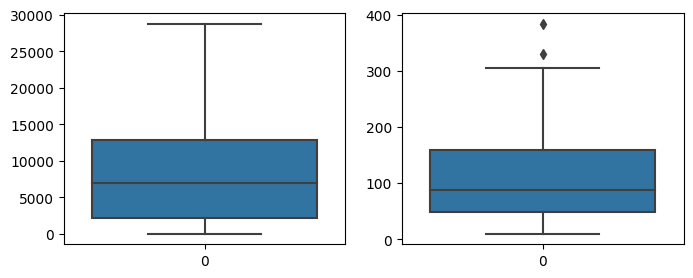

In [46]:
fig, axes=plt.subplots(1,2, figsize=(8,3))

sns.boxplot(auto_fluxes_burned['CH4']*(6.92e-7)*86400*16.04*1000, ax=axes[0]) # ch4 flux in mg/m2/d
sns.boxplot(auto_fluxes_unburned['CH4']*(6.92e-7)*86400*16.04*1000, ax=axes[1]) # ch4 flux in mg/m2/d

<Axes: xlabel='date', ylabel='CH4'>

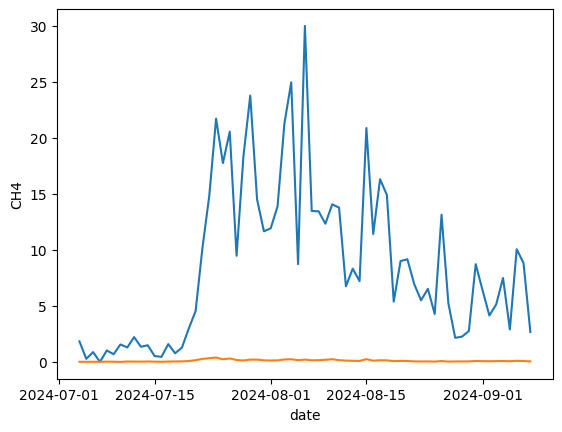

In [47]:
sns.lineplot(data = auto_fluxes_burned, x='date', y='CH4')
sns.lineplot(data = auto_fluxes_unburned, x='date', y='CH4')

In [48]:
inflows = pd.read_csv(inflows_path, header=None, delimiter=',')

inflows.columns = columns
inflows['dt'] = pd.to_datetime(inflows['Date'], format='%Y%m%d')

#merge updated influx values
inflows.loc[inflows['dt'].isin(date_range['date']), 'CH4'] = auto_fluxes_unburned['CH4'].to_list()
inflows = inflows.drop(columns=['dt'])

#inflows['DOC'] = 50.0
#inflows['POC'] = 100.0
#inflows['temp'] = -999.0

#save to data again
output_path = path_to_meteo_file.split('.dat')[0]+'_inflows.dat'
inflows.to_csv(output_path, index = False, header = False, sep=' ')